In [1]:
# !/usr/bin/env python
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import time
import ppxf as ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as miles_util
from IPython.display import clear_output
from multiprocessing import Pool
class HaltException(Exception): pass

### Files

In [2]:
fittable_file = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_GC/NGC_247/GCs/obj1/mean_NCS.fits'
out_dir = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/results_SP/NGC_247/GCs/'

model_dir = '/home/daniel/Documents/Swinburne/ultra-diffuse-galaxies/MILES_BASTI_KU_baseFe/'

write_out = True

### Model Parameters

change `zi` to be the redshift of source

change `FWHM_data` to be the FWHM resolution of source

change `mask_l` and `mask_h` to be same wavelength range as source

change `n_balmer` to be the number of H outputs in the source. If unknown, run with the wavelength range and check the output at the bottom of the following code block

`n_forbidden` is the number of non H outputs

In [3]:
#### FOR DF9 L_BL_4550 (out of focus)
zi = 0.00052 #redshift guess
FWHM_data = 4550 / 1800 # data resolution
start0=0 ;  start1=10
mask_l=3650; mask_h=5500 # wavelength masks to apply at either end
n_balmer = 3  ;  n_forbidden = 3   # need to know
region = "all_minus_10" # define a region to fit (default/all/no_mgb/blue/red/before_mgb/lt5100)

# ----------------------------------------------------------------------------------------------
# Dont touch below here in this code block
# ----------------------------------------------------------------------------------------------

###-----for all spectra the same
FWHM_tem = 2.5  # spectral resolution of MILES (change if using degraded models)
c = 299792.458  # Speed of light in kms-1
z = 0

### read if fits
hdu = fits.open(fittable_file)
t = hdu[0].data
th = hdu[0].header
##### Only use the wavelength range in common between galaxy and stellar library.
wave = th['CRVAL1'] + (np.arange(0., (th['NAXIS1'])) - 1) * th['CDELT1']
wave = wave / (1 + zi)
lamRange = np.array([np.min(wave), np.max(wave)])
frac = wave[1] / wave[0]  # Constant lambda fraction per pixel
velscale = np.log(frac) * c  # Constant velocity scale in km/s per pixel

FWHM_dif = np.sqrt(FWHM_tem ** 2 - FWHM_data ** 2)
mask = (wave > mask_l) & (wave < mask_h)
flux = t[mask]
wave = wave[mask]
lamRange = np.array([np.min(wave), np.max(wave)])

galaxy, logwave, VelScale = util.log_rebin(lamRange, flux, velscale=None)
wave = np.exp(logwave)
# galaxy = galaxy/np.median(galaxy)            # Normalize spectrum to avoid numerical issues
noise = np.full_like(galaxy, 0.01)  # Assume constant noise per pixel here

#########################------------------- Setup templates -----------------------
pathname = model_dir + '/Mku1.30*baseFe*.fits'  # EMILES Basti_KU_baseFe
nmod = 516
miles = miles_util.miles(pathname, VelScale, FWHM_data, FWHM_tem)
reg_dim = miles.templates.shape[1:]
stars_templates = miles.templates.reshape(miles.templates.shape[0], -1)
lam_range_gal = np.array([np.min(wave), np.max(wave)]) / (1 + z)
gas_templates, gas_names, line_wave = \
util.emission_lines(miles.log_lam_temp, lam_range_gal, FWHM_tem)
templates = np.column_stack([stars_templates, gas_templates])
dv = c * (miles.log_lam_temp[0] - np.log(wave[0]))  # km/s
### .determine_goodpixels needs ln(gal_lambda) vector, minmax of template lin-lambda, z
lamRangeTemp = np.exp(np.array([np.min(miles.log_lam_temp), np.max(miles.log_lam_temp)]))

if region == 'all':
    goodPixels = np.arange(0, len(galaxy), 1) # all
elif region == "all_minus_10":
    goodPixels = np.arange(10, len(galaxy)-10, 1) # all
elif region == 'default':
    goodPixels = util.determine_goodpixels(logwave, lamRangeTemp, z)
elif region == 'no_mgb':
    goodPixels = np.hstack((np.arange(0, 1430, 1), np.arange(1550, len(galaxy), 1)))
elif region == 'blue':
    goodPixels = np.arange(0, round(len(galaxy)/2), 1)
elif region == 'red':
    goodPixels = np.arange(round(len(galaxy)/2), len(galaxy)-25, 1)
elif region == 'before_mgb':
    goodPixels = np.arange(0, 1410, 1)
elif region == 'no_starting_hbeta':
    goodPixels = np.arange(175, len(galaxy), 1)
elif region == 'leo':
    goodPixels = np.arange(150, len(galaxy), 1)
elif region == 'lt5100':
    goodPixels = np.arange(0, 1128, 1)
elif region == 'lt5100-leo':
    goodPixels = np.arange(0, 1103, 1)
else:
    raise HaltException("Jonah you numpty define a fitting region!")

#########---------------- Fitting  -------------------------------------------
SigmaStart = 3 * VelScale  # if a good initial guess of the LOSVD parameters is not available
vel = c * np.log(1 + z)  # eq.(8) of Capp*n_teellari (2017)
start = [start0, start1]
n_temps = stars_templates.shape[1]
component = [0] * n_temps + [1] * (n_balmer + n_forbidden)  # will give us both balmer+forbidden together
gas_component = np.array(component) > 0  # gas_component=True for gas templates

moments = [2, 2]  # if balmer+forbiden
start = [start, start]
fixed = [[1, 1], [0, 0]]  # we will fix the Vr and sigma

/home/daniel/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in sqrt


Emission lines included in gas templates:
['Hdelta' 'Hgamma' 'Hbeta' '[OII]3726' '[OII]3729' '[OIII]5007_d']


### Kinematic Degree

Run as is.

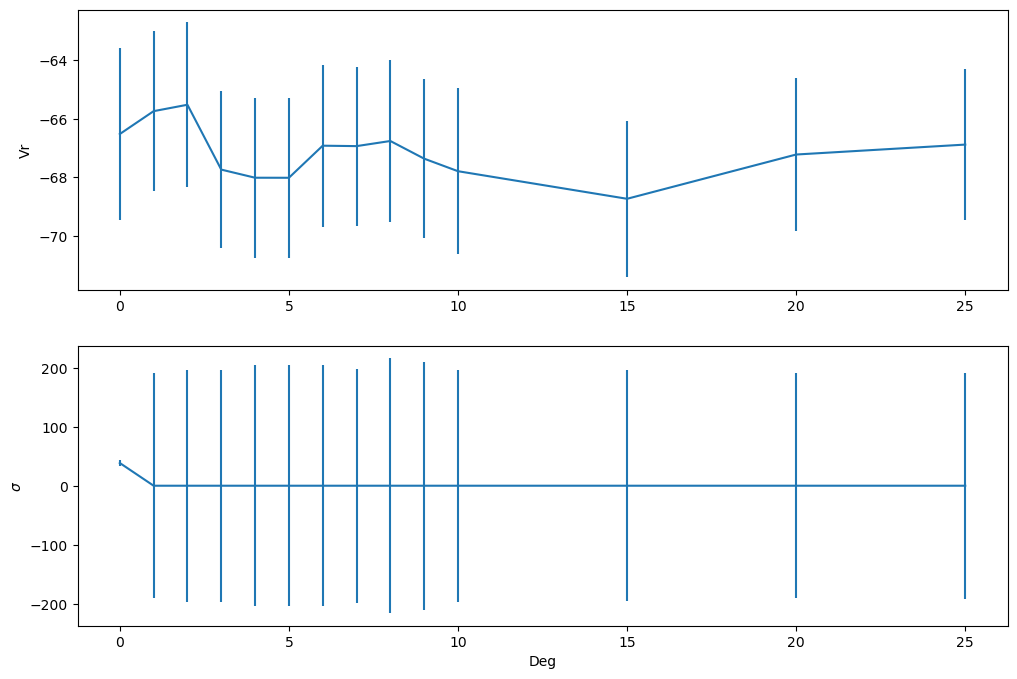

In [4]:
deg_kinem = np.asarray([0,1,2,3,4,5,6,7,8,9,10,15,20,25])  #series of degrees to check

def process_deg_kinem(i):
    pp = ppxf.ppxf.ppxf(templates, galaxy, noise, VelScale, start, goodpixels=goodPixels,
        plot=True, moments=moments, degree=i, mdegree=-1, vsyst=dv, lam=wave,
        clean=False, regul=False, reg_dim=reg_dim, component=component,
        gas_component=gas_component, gas_names=gas_names)

    noise1 = noise * np.sqrt(pp.chi2)
    vr = pp.sol[0][0]
    evr = pp.error[0][0] * np.sqrt(pp.chi2)
    sig = pp.sol[0][1]
    esig = pp.error[0][1] * np.sqrt(pp.chi2)
    return vr, evr, sig, esig

def run_deg_kinem(deg_kinem):
    results = []
    with Pool() as pool:
        for result in pool.imap(process_deg_kinem, range(len(deg_kinem))):
            results.append(result)
    
    vr = [result[0] for result in results]
    evr = [result[1] for result in results]
    sig = [result[2] for result in results]
    esig = [result[3] for result in results]
    return vr, evr, sig, esig

vr, evr, sig, esig = run_deg_kinem(deg_kinem)

clear_output()
data=[deg_kinem, vr, evr, sig, esig]

fig = plt.figure(1, figsize=(12, 8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.errorbar(data[0], data[1], yerr = data[2])
ax1.set_ylabel("Vr")

ax2.errorbar(data[0], data[3], yerr = data[4])
ax2.set_ylabel("$\sigma$")
ax2.set_xlabel("Deg")
if write_out:
    plt.savefig(out_dir+'deg_k.png')
plt.show()

### Choose Kinematic Degree

Update `deg_k` with best fit from the above code block 

In [5]:
deg_k = 5

### Multiplicative Degree

Run as is.

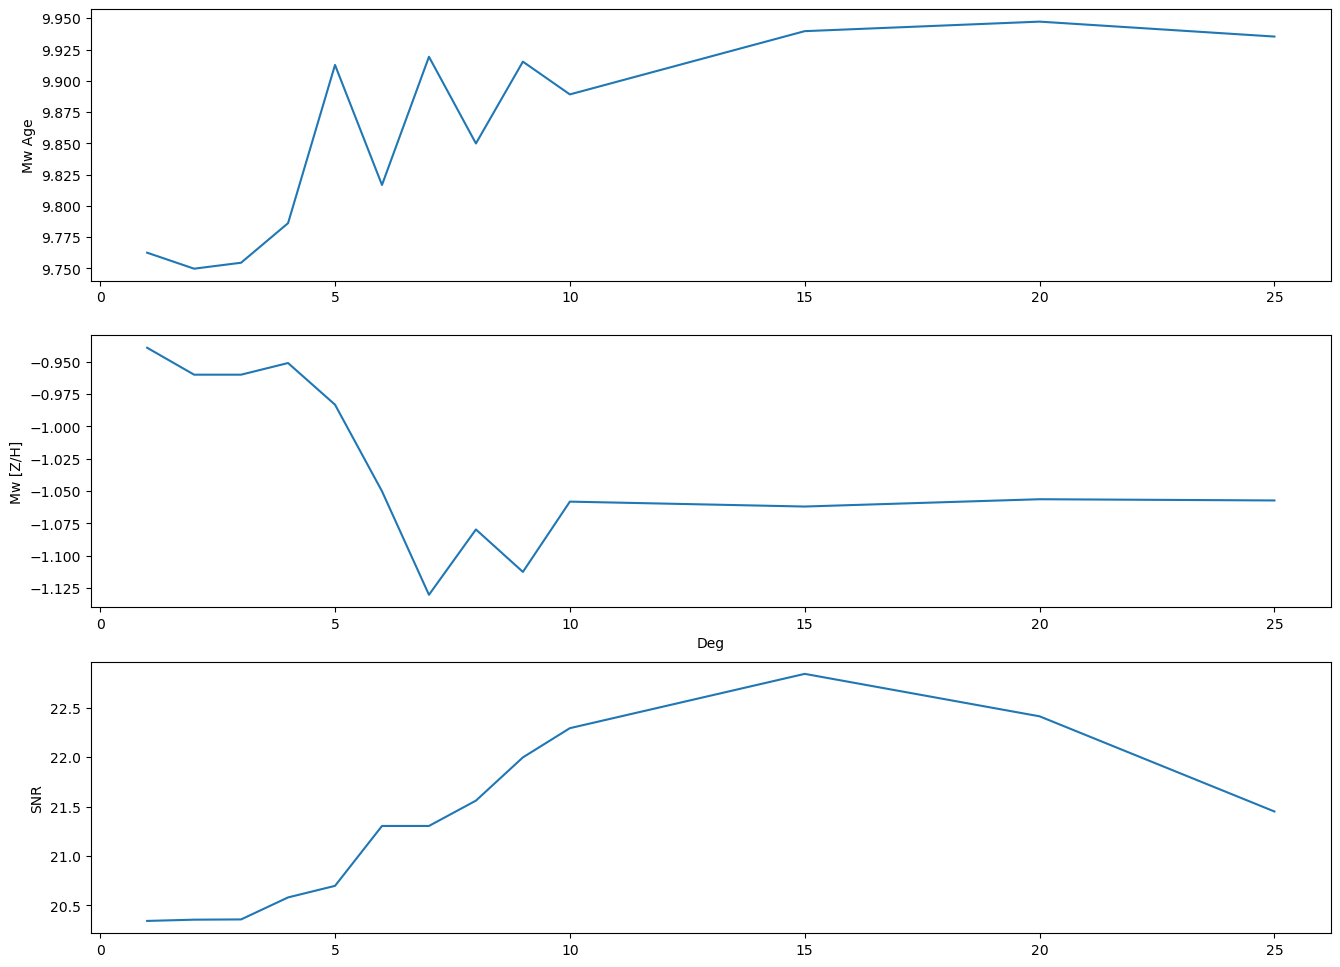

In [6]:
deg_pop = np.asarray([1,2,3,4,5,6,7,8,9,10,15,20,25])  #series of degrees to check

########## Once we select the degree for the kinematics
pp = ppxf.ppxf.ppxf(templates, galaxy, noise, VelScale, start, goodpixels=goodPixels,
      plot=False, moments=moments, degree=deg_k, mdegree=-1, vsyst=dv, lam=wave,
      clean=False, regul=False, reg_dim=reg_dim, component=component,
      gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

noise1 = noise * np.sqrt(pp.chi2)

def process_deg_pop(i):
    pp1 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
            plot=False, moments=moments, degree=deg_k, mdegree=deg_pop[i], vsyst=dv, lam=wave,
            clean=True, regul=False, reg_dim=reg_dim, component=component,
            gas_component=gas_component, gas_names=gas_names)#,velscale_ratio=velscale_ratio)

    weights = pp1.weights[~gas_component]
    weights = weights.reshape(reg_dim)/weights.sum()
    mwt = miles.mean_age_metal(weights)[0]
    mwz = miles.mean_age_metal(weights)[1]
    snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
    return mwt, mwz, snr

def run_deg_pop(deg_pop):
    results = []
    with Pool() as pool:
        for result in pool.imap(process_deg_pop, range(len(deg_pop))):
            results.append(result)
    
    mwt = [result[0] for result in results]
    mwz = [result[1] for result in results]
    snr = [result[2] for result in results]
    return mwt, mwz, snr

mwt, mwz, snr = run_deg_pop(deg_pop)

clear_output()

fig = plt.figure(2, figsize=(16, 12))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)

ax1.errorbar(deg_pop, mwt)
ax1.set_ylabel("Mw Age")

ax2.errorbar(deg_pop, mwz)
ax2.set_ylabel("Mw [Z/H]")

ax3.errorbar(deg_pop, snr)
ax3.set_ylabel("SNR")

ax2.set_xlabel("Deg")
if write_out:
    plt.savefig(out_dir+'deg_p.png')
plt.show()

### Choose Multiplicative Degree

Update `deg_p` with best fit from the above code block 

In [7]:
deg_p = 10

### Best Fit (No Regularisation)

record age and metalicity

Outliers: 1
Outliers: 1
Best Fit:       Vel     sigma
 comp. 0:       -68         1
 comp. 1:       -65       241
chi2/DOF: 0.7633
method = capfit; Jac calls: 5; Func calls: 135; Status: 2
Nonzero Templates: 9 / 642
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp: 1        Hdelta     0.1286     0.042     -65   241
Comp: 1        Hgamma     0.1117     0.042     -65   241
Comp: 1         Hbeta     0.2098     0.042     -65   241
Comp: 1     [OII]3726          0     0.075     -65   241
Comp: 1     [OII]3729     0.1623     0.075     -65   241
Comp: 1  [OIII]5007_d          0     0.053     -65   241
---------------------------------------------------------


<Figure size 640x480 with 0 Axes>

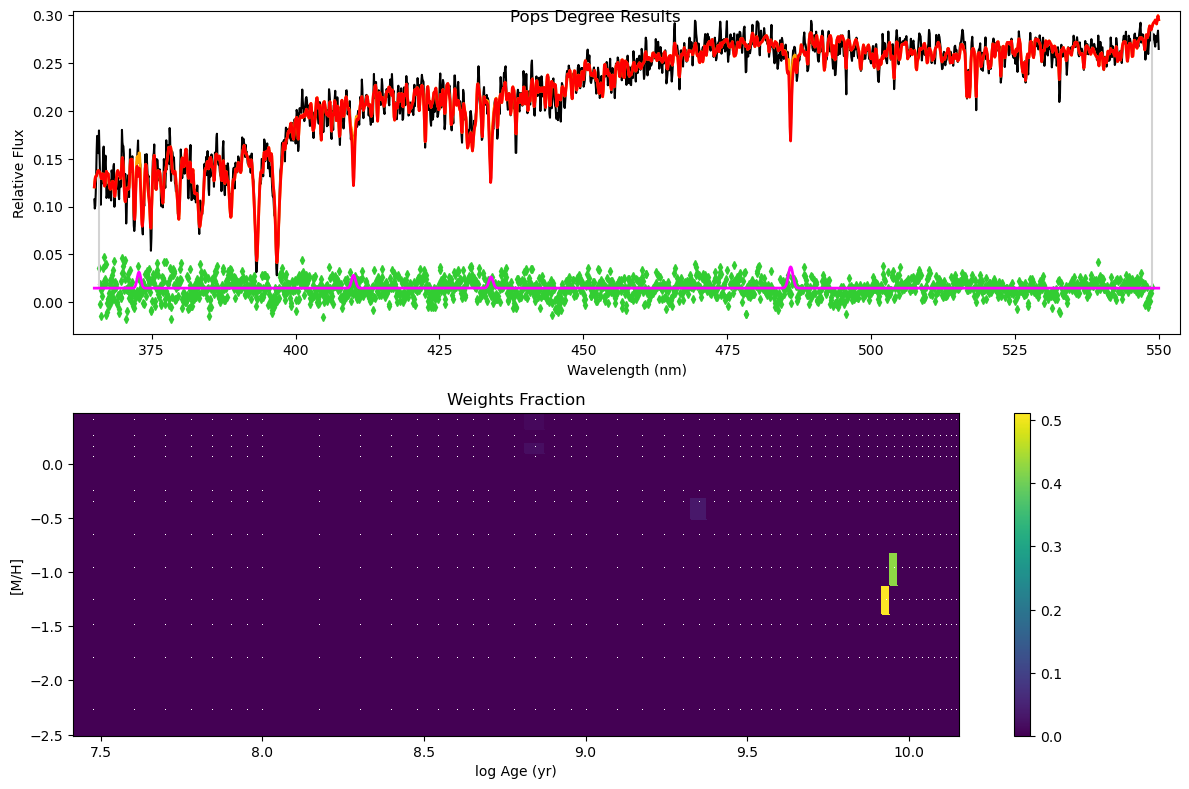

Weighted <logAge> [yr]: 9.89
Weighted <[M/H]>: -1.06
deg_k: 5
deg_p: 10


In [8]:
pp1 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
    plot=True, moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=wave,
    clean=True, regul=False, reg_dim=reg_dim, component=component,
    gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

plt.clf()
plt.figure(figsize=(12, 8))
plt.subplot(211)
pp1.plot()
plt.subplot(212)
weights = pp1.weights[~gas_component]
weights = weights.reshape(reg_dim)/weights.sum()
miles.plot(weights)
plt.tight_layout()
plt.suptitle("Pops Degree Results")
if write_out:
    plt.savefig(out_dir+'fit_noreg.png')
plt.show()

mwt, mwz = miles.mean_age_metal(weights)
snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
plt.show()

print(f'deg_k: {deg_k}')
print(f'deg_p: {deg_p}')

### Regularisation

After running, return to *Model Parameters* and update `reg_val` with best fit

In [ ]:
##### Select the thing from above than uncomment below and start playing around with regularisations

##### and we fix the pop deg to look for the regularization
pp1 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
       plot=True, moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=wave,
       clean=True, regul=False, reg_dim=reg_dim, component=component,
       gas_component=gas_component, gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)
plt.clf()
plt.subplot(211)
pp1.plot()
plt.subplot(212)
weights = pp1.weights[~gas_component]
weights = weights.reshape(reg_dim)/weights.sum()
miles.plot(weights)
plt.tight_layout()
plt.suptitle("Pops Degree Results")
plt.show()

mwt, mwz = miles.mean_age_metal(weights)
snr = np.median(pp1.bestfit) / np.std(galaxy - pp1.bestfit)
plt.show()

######## and now we change the regul parameter until reduced and absolute are the same
regul_err = np.asarray([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001])
# regul_err = np.asarray([0.000009, 0.000008, 0.000007, 0.000006, 0.000005, 0.000004, 0.000003, 0.000002])
# regul_err = np.asarray([0.00009, 0.00008, 0.00007, 0.00006, 0.00005, 0.00004, 0.00003, 0.00002])
# regul_err = np.asarray([0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002])
# regul_err = np.asarray([0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02])
# regul_err = np.asarray([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])

for i in range(len(regul_err)):
    if i == 0:
        mwt = np.zeros(len(regul_err))
        mwz = np.zeros(len(regul_err))
        lwt = np.zeros(len(regul_err))
        lwz = np.zeros(len(regul_err))
        snr = np.zeros(len(regul_err))
        red_chi = np.zeros(len(regul_err))
        reg_chi = np.zeros(len(regul_err))
        des_chi = np.zeros(len(regul_err))
        cur_chi = np.zeros(len(regul_err))

    pp2 = ppxf.ppxf.ppxf(templates, galaxy, noise1, VelScale, [pp.sol[0], pp.sol[1]], fixed=fixed, goodpixels=goodPixels,
        plot=False,
        moments=moments, degree=deg_k, mdegree=deg_p, vsyst=dv, lam=wave, clean=True,
        regul=1. / regul_err[i], reg_dim=reg_dim,
        component=component, gas_component=gas_component,
        gas_names=gas_names)  # ,velscale_ratio=velscale_ratio)

    weights = pp2.weights[~gas_component]
    weights = weights.reshape(reg_dim) / weights.sum()
    mwt[i], mwz[i] = miles.mean_age_metal(weights)
    snr[i] = np.median(pp2.bestfit) / np.std(galaxy - pp2.bestfit)
    red_chi[i] = pp2.chi2
    reg_chi[i] = pp2.chi2 * goodPixels.size
    des_chi[i] = np.sqrt(2 * goodPixels.size)
    cur_chi[i] = (pp2.chi2 - pp1.chi2) * goodPixels.size
    print('The desired chi was %.8g' % des_chi[i])
    print('The current chi was %.8g' % cur_chi[i])

    plt.clf()
    plt.subplot(211)
    pp2.plot()
    plt.subplot(212)
    miles.plot(weights)
    plt.tight_layout()
    plt.suptitle("The Regularisation_err was %.5f" % regul_err[i])
    plt.show()
    time.sleep(5)
    plt.close()

    data = [regul_err, red_chi, reg_chi, des_chi, cur_chi, mwt, mwz, snr]

    print('The regul_error was %.8f' % regul_err[i])

In [ ]:
from ppxf_kinematics import ppxf_kinematics
ppxf_kinematics(fittable_file, FWHM_data, deg_k, wav_min, wav_max, fit='all', mdegree=4)